In [1]:
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['svg.fonttype'] = 'none'

arr = np.asarray
import scanpy as sc
sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

In [2]:
import sys
import glob
sys.path.append("./code/")
from hic_zscore_functions import *
import initialize
# reload(initialize)
from initialize import *
from aux_functions import *

treg_250kb = cooler.Cooler('./Treg_all.mcool::/resolutions/250000')
treg_50kb = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
tcon_250kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/250000')
tcon_50kb = cooler.Cooler('./Tconv_all.mcool::/resolutions/50000')

(chromsizes, parsed_chroms, region_to_inds, 
    all_region_to_ind, inds_to_region, all_ind_to_region, 
    chrom_to_start, chrom_to_end) = initialize_helper_vars(treg_250kb)

import pickle
gene_to_ind = pickle.load(open('gene_to_ind.p', 'rb'))

In [3]:
%load_ext autoreload
%autoreload
import scanpy as sc

sc.settings.set_figure_params(dpi=80, color_map='coolwarm', frameon=True)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({"axes.grid.axis" : 'both'})
plt.rcParams.update({"axes.grid" : True})

plt.rcParams.update({
    'axes.labelsize': 14,       # x and y labels' font size
    'xtick.labelsize': 8,      # x tick labels' font size
    'ytick.labelsize': 8,      # y tick labels' font size
    'axes.titlesize': 14,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'legend.fontsize': 6,      # Legend font size
})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams.update({
    'axes.labelsize': 8,       # x and y labels' font size
    'xtick.labelsize': 6,      # x tick labels' font size
    'ytick.labelsize': 6,      # y tick labels' font size
    'axes.titlesize': 10,        # Axes title font size
    'patch.linewidth' : .35,
    'lines.linewidth' : .5,
    'xtick.major.pad' : 2,
    'ytick.major.pad' : 2,

})
plt.rcParams['axes.linewidth'] = .25
plt.rcParams['xtick.major.width'] = .25
plt.rcParams['ytick.major.width'] = .25
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['grid.linewidth'] = .25

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

plt.rcParams['axes.facecolor'] = 'none' # Or any suitable colour...
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'none'

In [4]:
CHROMS_TO_USE = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '3', '4', '5', '6', '7', '8', '9', 'X']

In [5]:
from matplotlib import transforms
def get_off_diag_mat_by_ind(cool, ind1, ind2, d, balance=False):
    chrom1, s1, _ = all_ind_to_region[ind1-d]
    chrom1, _, e1 = all_ind_to_region[ind1+d]
    
    chrom2, s2, _ = all_ind_to_region[ind2-d]
    chrom2, _, e2 = all_ind_to_region[ind2+d]
    if 'chr' in cool.chromnames[0]:
        m = cool.matrix(balance=balance).fetch(('chr' + chrom1, s1, e1), ('chr' + chrom2, s2, e2))
    else:
        m = cool.matrix(balance=balance).fetch((chrom1, s1, e1), (chrom2, s2, e2))
    return m


def get_off_diag_mat_by_places(cool, place1, place2, balance=False):
    chrom1, s1, e1 = place1
    chrom2, s2, e2 = place2
    if 'chr' in cool.chromnames[0]:
        m = cool.matrix(balance=balance).fetch(('chr' + chrom1, s1, e1), ('chr' + chrom2, s2, e2))
    else:
        m = cool.matrix(balance=balance).fetch((chrom1, s1, e1), (chrom2, s2, e2))
    return m

In [6]:
def get_tcon_mat(place1, place2, resolution=5000, balance=False, filesoi=None):
    cool = cooler.Cooler(f'./Tconv_all.mcool::/resolutions/{resolution}')
    try:
        mat = get_off_diag_mat_by_places(cool, place1, place2, balance=balance)
    except Exception as e:
        print(e)
    m = mat.astype(float)
    return m, place1, place2


def get_treg_mat(place1, place2, resolution=5000, balance=False, filesoi=None):
    cool = cooler.Cooler(f'./Treg_all.mcool::/resolutions/{resolution}')
    try:
        mat = get_off_diag_mat_by_places(cool, place1, place2, balance=balance)
    except Exception as e:
        print(e)
    m = mat.astype(float)
    return m, place1, place2

def get_non_treg_mat(place1, place2, filesoi, d=1, resolution=5000, **kwargs):
    ms = []
    files = []
    filesoi = cormat[(cormat.loc['./Treg_all.mcool'] > .8)].index
    for file in filesoi:
        try:
            cool = cooler.Cooler(f'{file}::/resolutions/{resolution}')
            mat = get_off_diag_mat_by_places(cool, place1, place2, balance=False)
        except Exception as e:
            print(e)
        ms.append(mat)
        files.append(file)
    ms = arr(ms)
    collapsemat = np.nansum(ms, axis=0).astype(float)
    m = collapsemat
    return m, place1, place2

### Check correlations; Make final mega dataset

In [7]:
from skimage.feature import peak_local_max
from get_focal_contacts import *


In [8]:
import math

def plot_inds(mat, i1, i2, d, ax=None, trans_func = lambda x: x, **kwargs):
    sl1 = slice(i1-d, i1+d+1)
    sl2 = slice(i2-d, i2+d+1)
    submat = trans_func(mat[sl1, sl2])
    if ax is None:
        fig, ax = plt.subplots()
    ax.matshow(submat, **kwargs)
    return submat.copy()

In [9]:
from get_focal_contacts_with_peak_prominence_refine import *
def make_s29_b():
    ### Ctla4 <-> Stk17b
    inds = [[215, 243]]
    chrom = all_ind_to_region[inds[0][0]][0]
    for i1, i2 in inds:
        s = (i1 - chrom_to_start[chrom])*250_000+35_000
        e = (i2 - chrom_to_start[chrom])*250_000+45_000
        grange1, grange2 = (chrom, s, s+5_000), (chrom, e, e+5_000)
        fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=160_000, 
                                                 logp_co = 15,
                                          ignore_set = {'Chd4', 'Lag3', 'Lpar5', 'Gnb3', '4930557K07Rik', 'Cops7a', 
                                                        'Cdca3', 'Mlf2', 'Usp5', 'Lrrc23', 'Lpcat3', 'Gm45234', 'Pianp', 
                                                        '2010008C14Rik', 'A230083G16Rik', 'Cd4', 'Ptpn6', 'Tpi1', 'P3h3', 'Phb2', 
                                                        'Gm29008', 'Gpr162', 'Eno2', 'Zfp384', 'Emg1', 'Ing4', 'Gm15884', 'Gm23547', 'Gm23851', 
                                                        'Grcc10', 'Spsb2', 'Atn1', 'Gm23751', 'Ptms', 'Acrbp', 'Gm20531',  'Gm44597', 
                                                        '4930402H05Rik', 'Gm44278', 'Iqsec1', 'Gm44002', 'Gm14573',
                                                       'Park7', 'Errfi1', 'Camta1', 'Gm23405',
                                                        'Mmp7', 'Mmp20', 'Yap1', 'Birc3', 'AV064505', 'Gm20416', 'Gm47214', # 'Panx1', # '1700012B09Rik', # 'Hephl1', 'Gm16302', 'Mre11a', # 'Ankrd49',
                                                    'Gm23762', 'Gm38388', '2310016D23Rik', 'Gm38137', 'Gm11579', 'Gm37198',
                                                        'Gm37863', 'Dnah7a', 'Gm24251',
    
                                                       })
        axs[1].set_ylim([-.5, 2.5])
        plt.gcf().savefig("./plots/paper/s28/ctla4.pdf", bbox_inches='tight')    
    

    ### Ikzf2 <-> Idh1
    
    chrom = '1'
    inds = [[260, 278]]
    for i1, i2 in inds:
        s = i1*250_000+155_000
        e = i2*250_000+155_000
        grange1, grange2 = (chrom, s, s+50_000), (chrom, e, e+50_000)
        grange1 = extend_l(grange1, 100_000)
        grange2 = extend_l(grange2, 100_000)
    
        make_simple_plot_grange_collapsing(grange1, grange2, extend_by=0, logp_co = 15,
                                          ignore_set={'Gm37930', 'Spag16', 'Gm28112', 'Gm29112', 'Crygc', 'Crygb', 'Crygd', 'Gm28845', 'Pth2r', 'D630023F18Rik', 'Cryga'})
        plt.gcf().savefig("./plots/paper/s28/ikzf2_idh1.pdf", bbox_inches='tight')


    ### Socs2 <-> Metl25
    inds = [[6008, 5966]]
    chrom = all_ind_to_region[inds[0][0]][0]
    for i1, i2 in inds:
        s = (i1 - chrom_to_start[chrom])*250_000+105_000
        e = (i2 - chrom_to_start[chrom])*250_000+165_000
        grange1, grange2 = (chrom, s, s+5_000), (chrom, e, e+5_000)
        fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=180_000, 
                                                 logp_co = 15,
                                          ignore_set = {'Chd4', 'Lag3', 'Lpar5', 'Gnb3', '4930557K07Rik', 'Cops7a', 
                                                        'Cdca3', 'Mlf2', 'Usp5', 'Lrrc23', 'Lpcat3', 'Gm45234', 'Pianp', 
                                                        '2010008C14Rik', 'A230083G16Rik', 'Cd4', 'Ptpn6', 'Tpi1', 'P3h3', 'Phb2', 
                                                        'Gm29008', 'Gpr162', 'Eno2', 'Zfp384', 'Emg1', 'Ing4', 'Gm15884', 'Gm23547', 'Gm23851', 
                                                        'Grcc10', 'Spsb2', 'Atn1', 'Gm23751', 'Ptms', 'Acrbp', 'Gm20531',  'Gm44597', 
                                                        '4930402H05Rik', 'Gm44278', 'Iqsec1', 'Gm44002', 'Gm14573',
                                                       'Park7', 'Errfi1', 'Camta1', 'Gm23405',
                                                        'Mmp7', 'Mmp20', 'Yap1', 'Birc3', 'AV064505', 'Gm20416', 'Gm47214',
                                                        'Gm44645', 'Gm23020', 'Gm26176', 'A730056A06Rik', 'Gm44738', 'Gm44739', 
                                                        'Gm44736', 'Gm44737', 'Gm44734', 'Gm44758', 'Gm44552', '1810026B05Rik', 'C130083A15Rik', 
                                                        'Gm44553', 'Gm44686',
                                                        'Gm44934', 'Gm19656', 'Gm45132', 'Gm23040', 'A630091E08Rik', 'Gm15506', '2310039L15Rik', '5730420D15Rik', 'Gm47599', 'Gm48880', 'Gm48882', 'Gm25342', 'Gm24237', 'Gm48363', 'n-R5s80', 'Gm48298', 'Ccdc59',
    
    
    
                                                       })
        axs[1].set_ylim([-.5, 2.5])
        plt.gcf().savefig("./plots/paper/s28/socs2.pdf", bbox_inches='tight')

    
    ### Emsy/Lrrc32 <-> Chd2
    inds = [[4279, 4380]]
    chrom = all_ind_to_region[inds[0][0]][0]
    for i1, i2 in inds:
        s = (i1 - chrom_to_start[chrom])*250_000+235_000
        e = (i2 - chrom_to_start[chrom])*250_000+165_000
        grange1, grange2 = (chrom, s, s+5_000), (chrom, e, e+5_000)
        fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=160_000, 
                                                 logp_co = 15,
                                          ignore_set = {'Chd4', 'Lag3', 'Lpar5', 'Gnb3', '4930557K07Rik', 'Cops7a', 
                                                        'Cdca3', 'Mlf2', 'Usp5', 'Lrrc23', 'Lpcat3', 'Gm45234', 'Pianp', 
                                                        '2010008C14Rik', 'A230083G16Rik', 'Cd4', 'Ptpn6', 'Tpi1', 'P3h3', 'Phb2', 
                                                        'Gm29008', 'Gpr162', 'Eno2', 'Zfp384', 'Emg1', 'Ing4', 'Gm15884', 'Gm23547', 'Gm23851', 
                                                        'Grcc10', 'Spsb2', 'Atn1', 'Gm23751', 'Ptms', 'Acrbp', 'Gm20531',  'Gm44597', 
                                                        '4930402H05Rik', 'Gm44278', 'Iqsec1', 'Gm44002', 'Gm14573',
                                                       'Park7', 'Errfi1', 'Camta1', 'Gm23405',
                                                        'Mmp7', 'Mmp20', 'Yap1', 'Birc3', 'AV064505', 'Gm20416', 'Gm47214',
                                                        'Gm44645', 'Gm23020', 'Gm26176', 'A730056A06Rik', 'Gm44738', 'Gm44739', 
                                                        'Gm44736', 'Gm44737', 'Gm44734', 'Gm44758', 'Gm44552', '1810026B05Rik', 'C130083A15Rik', 
                                                        'Gm44553', 'Gm44686',
                                                        'Gm44934', 'Gm19656', 'Gm45132', 'Gm23040', 'A630091E08Rik', 'Gm15506',
    
    
                                                       })
        axs[1].set_ylim([-.5, 2.5])
        plt.gcf().savefig("./plots/paper/s28/emsy.pdf", bbox_inches='tight')


    ### Cd38 / Kcnip4
    inds = [[2972, 2954]]
    chrom = all_ind_to_region[inds[0][0]][0]
    for i1, i2 in inds:
        s = (i1 - chrom_to_start[chrom])*250_000+105_000
        e = (i2 - chrom_to_start[chrom])*250_000+135_000
        grange1, grange2 = (chrom, s, s+5_000), (chrom, e, e+5_000)
        fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=160_000, 
                                                 logp_co = 15,
                                          ignore_set = {'Chd4', 'Lag3', 'Lpar5', 'Gnb3', '4930557K07Rik', 'Cops7a', 
                                                        'Cdca3', 'Mlf2', 'Usp5', 'Lrrc23', 'Lpcat3', 'Gm45234', 'Pianp', 
                                                        '2010008C14Rik', 'A230083G16Rik', 'Cd4', 'Ptpn6', 'Tpi1', 'P3h3', 'Phb2', 
                                                        'Gm29008', 'Gpr162', 'Eno2', 'Zfp384', 'Emg1', 'Ing4', 'Gm15884', 'Gm23547', 'Gm23851', 
                                                        'Grcc10', 'Spsb2', 'Atn1', 'Gm23751', 'Ptms', 'Acrbp', 'Gm20531',  'Gm44597', 
                                                        '4930402H05Rik', 'Gm44278', 'Iqsec1', 'Gm44002', 'Gm14573',
                                                       'Park7', 'Errfi1', 'Camta1', 'Gm23405',
                                                        'Mmp7', 'Mmp20', 'Yap1', 'Birc3', 'AV064505', 'Gm20416', 'Gm47214', # 'Panx1', # '1700012B09Rik', # 'Hephl1', 'Gm16302', 'Mre11a', # 'Ankrd49',
                                                        'Prom1', 'Gm43183', 'Gm7879', 'Gm43184', 'Gm16014', 'Gm42555', 'Gm43182', 'Gm42716', 'Gm16015', 'Gm43181', 'Gm42535', 'Slit2', '5730480H06Rik', 'Gm42534', 'Gm42537', 'Gm42462', 'Cc2d2a',
    
                                                       })
        axs[1].set_ylim([-.5, 2.5])
        plt.gcf().savefig("./plots/paper/s28/cd38.pdf", bbox_inches='tight')

    ### Izumo1r / Birc2/3
    inds = [[5117, 5145]]
    chrom = all_ind_to_region[inds[0][0]][0]
    for i1, i2 in inds:
        s = (i1 - chrom_to_start[chrom])*250_000+65_000
        e = (i2 - chrom_to_start[chrom])*250_000+165_000
        grange1, grange2 = (chrom, s, s+5_000), (chrom, e, e+5_000)
        fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=160_000, 
                                                 logp_co = 15,
                                          ignore_set = {'Chd4', 'Lag3', 'Lpar5', 'Gnb3', '4930557K07Rik', 'Cops7a', 
                                                        'Cdca3', 'Mlf2', 'Usp5', 'Lrrc23', 'Lpcat3', 'Gm45234', 'Pianp', 
                                                        '2010008C14Rik', 'A230083G16Rik', 'Cd4', 'Ptpn6', 'Tpi1', 'P3h3', 'Phb2', 
                                                        'Gm29008', 'Gpr162', 'Eno2', 'Zfp384', 'Emg1', 'Ing4', 'Gm15884', 'Gm23547', 'Gm23851', 
                                                        'Grcc10', 'Spsb2', 'Atn1', 'Gm23751', 'Ptms', 'Acrbp', 'Gm20531',  'Gm44597', 
                                                        '4930402H05Rik', 'Gm44278', 'Iqsec1', 'Gm44002', 'Gm14573',
                                                       'Park7', 'Errfi1', 'Camta1', 'Gm23405',
                                                        'Mmp7', 'Mmp20', 'Yap1', 'AV064505', 'Gm20416', 'Gm47214', 'Panx1',
                                                        '1700012B09Rik', # 'Hephl1', 'Gm16302', 'Mre11a', # 'Ankrd49',,
                                                        'Gpr83','Gm16302',
                                                       })
        axs[1].set_ylim([-.5, 2.5])
        plt.gcf().savefig("./plots/paper/s28/izumo1r.pdf", bbox_inches='tight')

1


In [10]:
from get_focal_contacts_with_peak_prominence_refine import *
def make_figure_s29a():
    l1 = list(deepcopy(all_ind_to_region[2315]))
    l1[1] -= 0*10_000
    l1[2] -= 0*10_000
    
    l2 = list(deepcopy(all_ind_to_region[2326]))
    l2[1] -= 100_000
    l2[2] -= 100_000
    
    chrom = '16'
    grange1, grange2 = l1, l2
    fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=100_000, 
                                             logp_co = 15,
                                      ignore_set = {
                                          'Olfr206', 'Olfr205', 'Olfr204',  'Olfr203', 'Olfr209', '1700022E09Rik',  'AC154473.1',
                                          'Gm23374', 'Csnka2ip','Cggbp1', 'Htr1f',
                                          'Arl6', 'Crybg3', 'Gabrr3', 'Olfr70',  'Tmem8b',  'Sit1',  'Msmp',  'Rusc2',  'Gba2',  'Hint2',  'Spaar',  'Npr2',  'Tpm2',  'Hrct1',  'Tln1',  'Olfr71',  'Spag8',  'Ccdc107',  'Arhgef39',  'Car9',  'AL732506.1',  'Fam166b',  'Rgp1',  'Fam221b',  'Tesk1',  'Rmrp',  'Aqp7', 'Aqp3', 'Spink4', 'Smu1', 'Chmp5', 'Nfx1', 'Dnaja1',
    
    
                                      },
                                                   skip_gm=True, skip_rik=True)
    axs[1].set_ylim([-.5, 2.5])
    
    plt.gcf().savefig("./plots/paper/s29/A2bot.pdf", bbox_inches='tight')    
    
    
    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
        
    fig = plot_from_cooler_and_anchors(coolfile, l1, l2, d=100_000, cols=1,
                                      fgsz=(40*mm, 40*mm))
    plt.grid(False)
    plt.title('Treg (50kb)')
    plt.gcf().savefig("./plots/paper/s29/A2top.pdf", bbox_inches='tight')    
    
    
    l1 = all_ind_to_region[6293]
    l2 = all_ind_to_region[6327]
    
    chrom = '16'
    grange1, grange2 = l1, l2
    fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=200_000, 
                                             logp_co = 15,
                                      ignore_set = {'Gpx3', 'Rapgef6', 'Slc36a1os', 'Ccdc69', 'Slc36a2', 'Hint1', 'Lyrm7os', 'Lyrm7', 'Slc36a3os', 'Adam19', 'Nipal4', 'Timd2', 'Dppa1', 'BC053393', 'Havcr2', 'Cyfip2', 'Med7', 'Fndc9',
                                      },
                                                   skip_gm=True, skip_rik=True)
    axs[1].set_ylim([-.5, 2.5])
    
    plt.gcf().savefig("./plots/paper/s29/A1bot.pdf", bbox_inches='tight')    
    
    
    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
        
    fig = plot_from_cooler_and_anchors(coolfile, l1, l2, d=200_000, cols=1,
                                      fgsz=(40*mm, 40*mm))
    plt.grid(False)
    plt.title('Treg (50kb)')
    plt.gcf().savefig("./plots/paper/s29/A1top.pdf", bbox_inches='tight')    
    
    
    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
    
    l1 = list(deepcopy(all_ind_to_region[2722]))
    l1[1] -= 150_000
    l1[2] -= 150_000
    l2 = all_ind_to_region[2757]
    
    fig, axs, _ = make_simple_plot_grange_collapsing(l1, l2, extend_by=550_000, 
                                             logp_co = 15,
                                      ignore_set = {
    'Park7', '1700045H11Rik', 'Nol9', 'Phf13', 'Thap3', 'Tas1r1', 'Dnajc11', 'Zbtb48', 'Klhl21', 'Gm37141', 
    'Tnfrsf9',  '4930455G09Rik', '4930589P08Rik', 'Errfi1', 'Gm13090', 'Gm23405', 'Gm13049', 'Vamp3', 'Uts2', 'Gm9768', 'Per3', 'Efhd2', 'Gm13052', 'Ctrc', 'Prdm2', 'Gm29367', 'Fhad1', 'Ctrcos', 'Tmem51os1', 'Gm37624', 'Fhad1os2', 'Gm13062', 'Gm13053', 'Fhad1os1', 'Casp9', 'Cela2a',
                                      },
                                                   skip_gm=False, skip_rik=False)
    axs[1].set_ylim([-.5, 2.5])
    plt.gcf().savefig("./plots/paper/s29/A3bot.pdf", bbox_inches='tight')

    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
    
    l1 = list(deepcopy(all_ind_to_region[2722]))
    l1[1] -= 150_000
    l1[2] -= 150_000
    l2 = all_ind_to_region[2757]
    
    fig = plot_from_cooler_and_anchors(coolfile, l1, l2, d=550_000, cols=1, fgsz=(40*mm, 40*mm))
    plt.grid(False)
    plt.title('Treg (50kb)')
    plt.gcf().savefig("./plots/paper/s29/A3top.pdf", bbox_inches='tight')    

In [11]:
from plotting_functions import *
def make_figure_6a():
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
    fig = plot_from_cooler_and_anchors(coolfile, 
                                  ('16', 59500000, 59550000),
                                  ('16', 64800000, 64850000),
                                d=600_000, cols=1)
    plt.grid(False)
    plt.title('Treg (50kb)')
    fig.savefig("./plots/compendium_plots/chr16_zoom_out.pdf", bbox_inches='tight')
    
    fig = plot_from_cooler_and_anchors(coolfile, 
                                  ('16', 59500000, 59550000),
                                  ('16', 64800000, 64850000),
                                d=200_000, cols=1)
    plt.grid(False)
    plt.title('Treg (50kb)')
    fig.savefig("./plots/compendium_plots/chr16_zoom_in.pdf", bbox_inches='tight')
    
    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/5000')
    fig = plot_from_cooler_and_anchors(coolfile, 
                                  ('16', 59500000, 59550000),
                                  ('16', 64800000, 64850000),
                                  d=200_000, cols=1)
    plt.grid(False)
    plt.title('Treg (5kb)')
    fig.savefig("./plots/compendium_plots/chr16_zoom_in_5kb.pdf", bbox_inches='tight')
    

    fig, _ = make_comprehensive_plot_grange_collapsing(
                                                  ('16', 59500000, 59550000),
                                                  ('16', 64800000, 64850000),
                                                  extend_by=200_000,
                                                  logp_co=15,
                                                    linewidth=.75,
                                           );
    fig.savefig("./plots/compendium_plots/chr16_zoom_in_5kb_compend.pdf", bbox_inches='tight')
    
    
    ### With genes
    
    chrom = '16'
    grange1, grange2 = ('16', 59500000, 59550000), ('16', 64800000, 64850000)
    fig, axs, _ = make_simple_plot_grange_collapsing(grange1, grange2, extend_by=200_000, 
                                             logp_co = 15,
                                      ignore_set = {
                                          'Olfr206', 'Olfr205', 'Olfr204',  'Olfr203', 'Olfr209', '1700022E09Rik',  'AC154473.1',
                                          'Gm23374', 'Csnka2ip','Cggbp1', 'Htr1f',
                                          'Arl6', 'Crybg3', 'Gabrr3', 
                                      })
    axs[1].set_ylim([-.5, 2.5])
    plt.gcf().savefig("./plots/paper/fig6/A.pdf", bbox_inches='tight')    

#### Make Figure 6A

In [12]:
goodinds = pickle.load(open('./intermediate_files/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./intermediate_files/merged_clustdict', 'rb'))

In [13]:
%autoreload 2
from plotting_functions import *


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


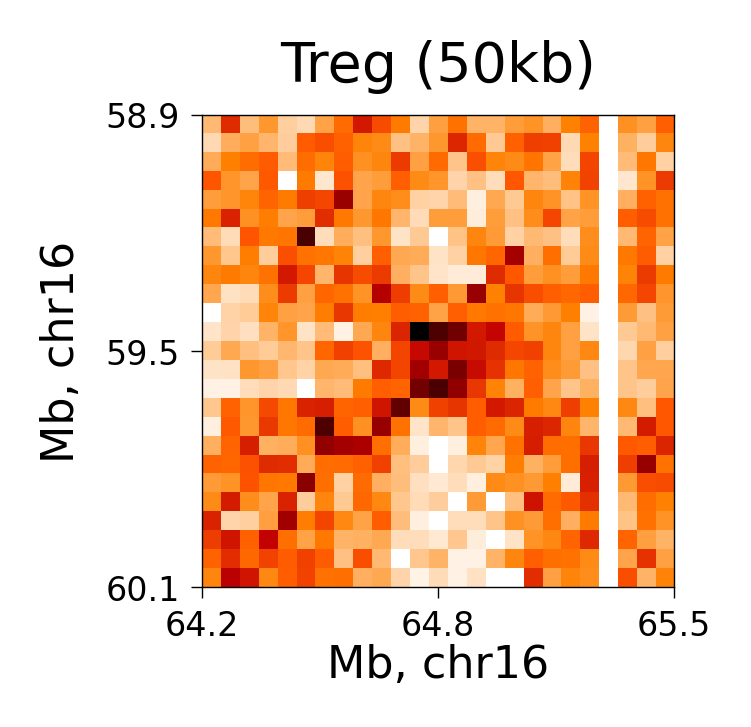

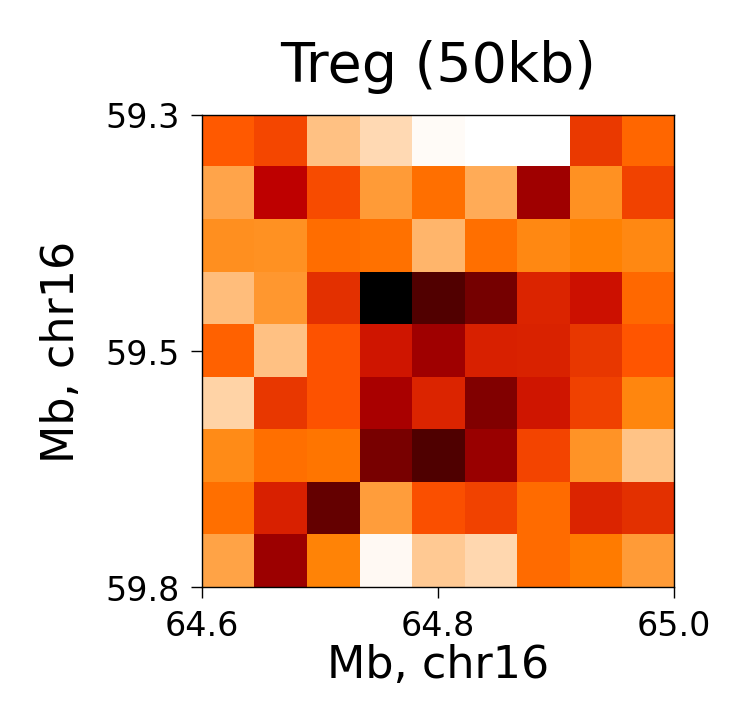

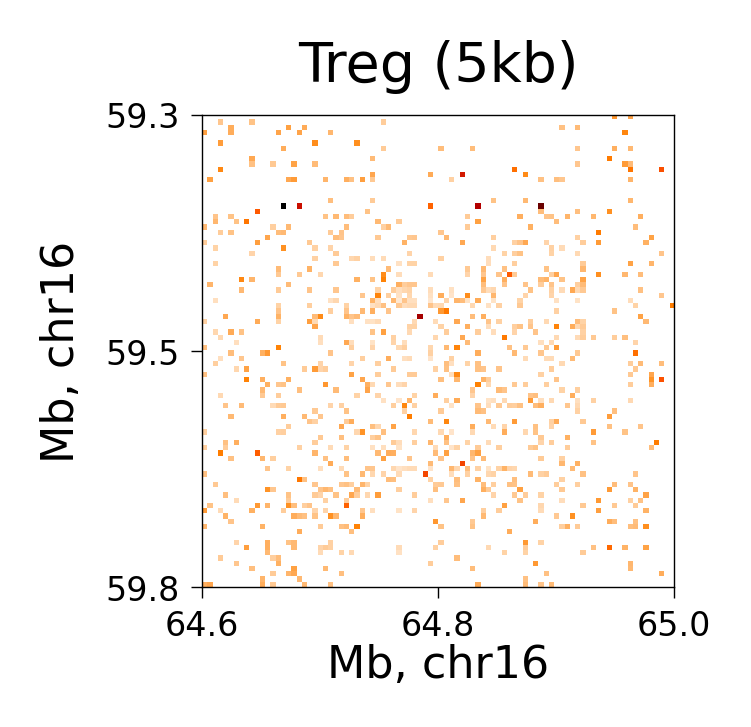

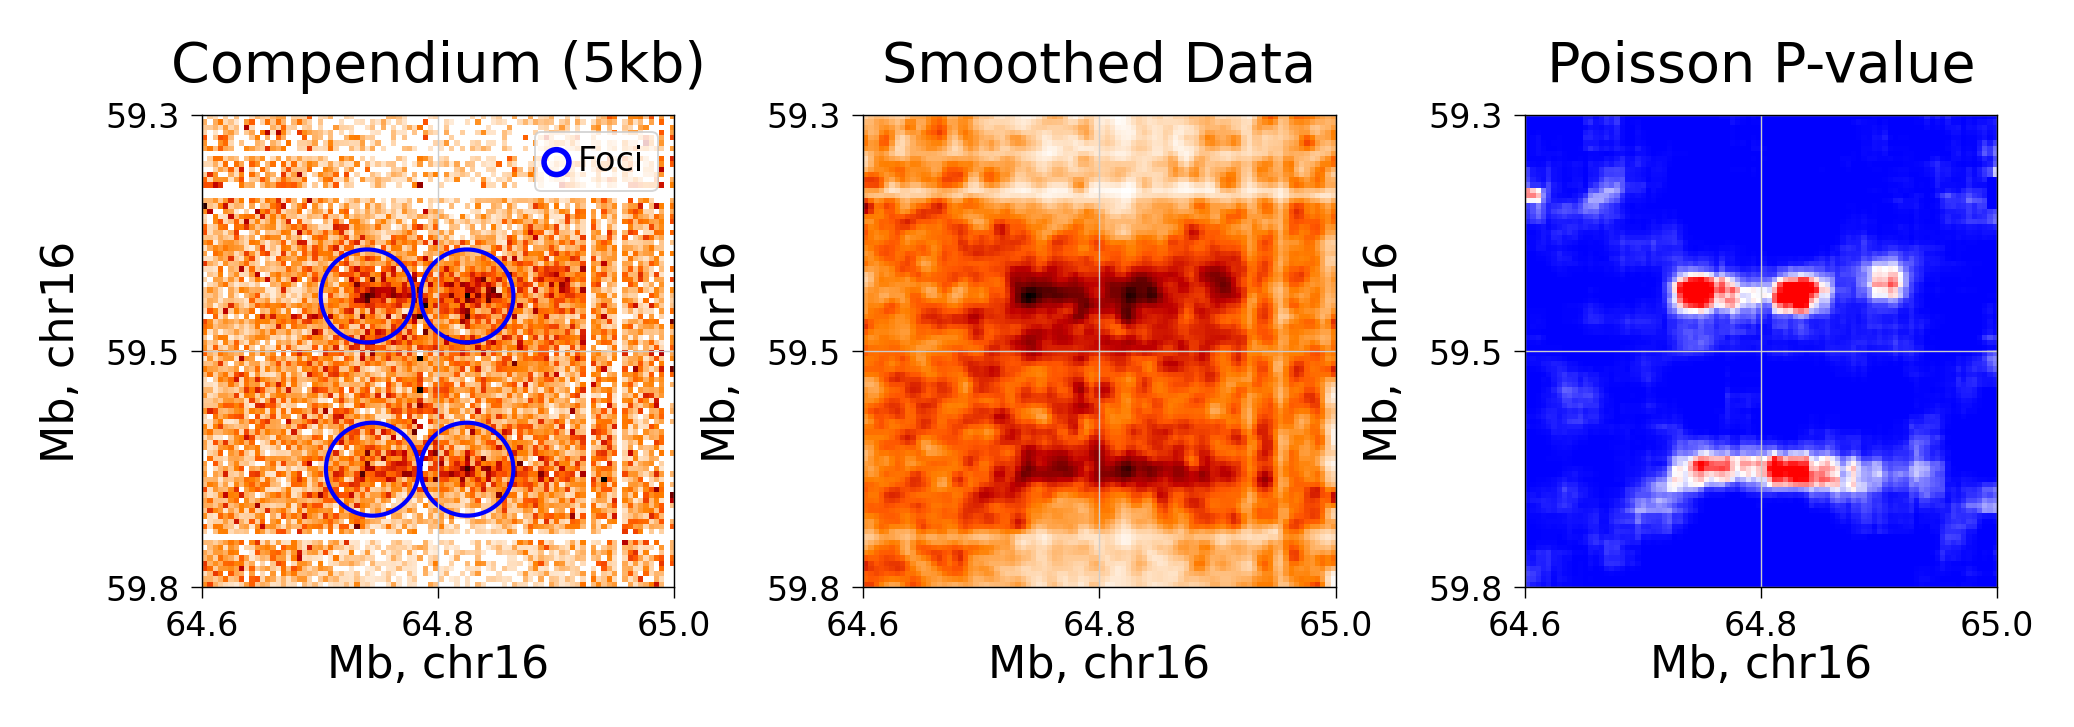

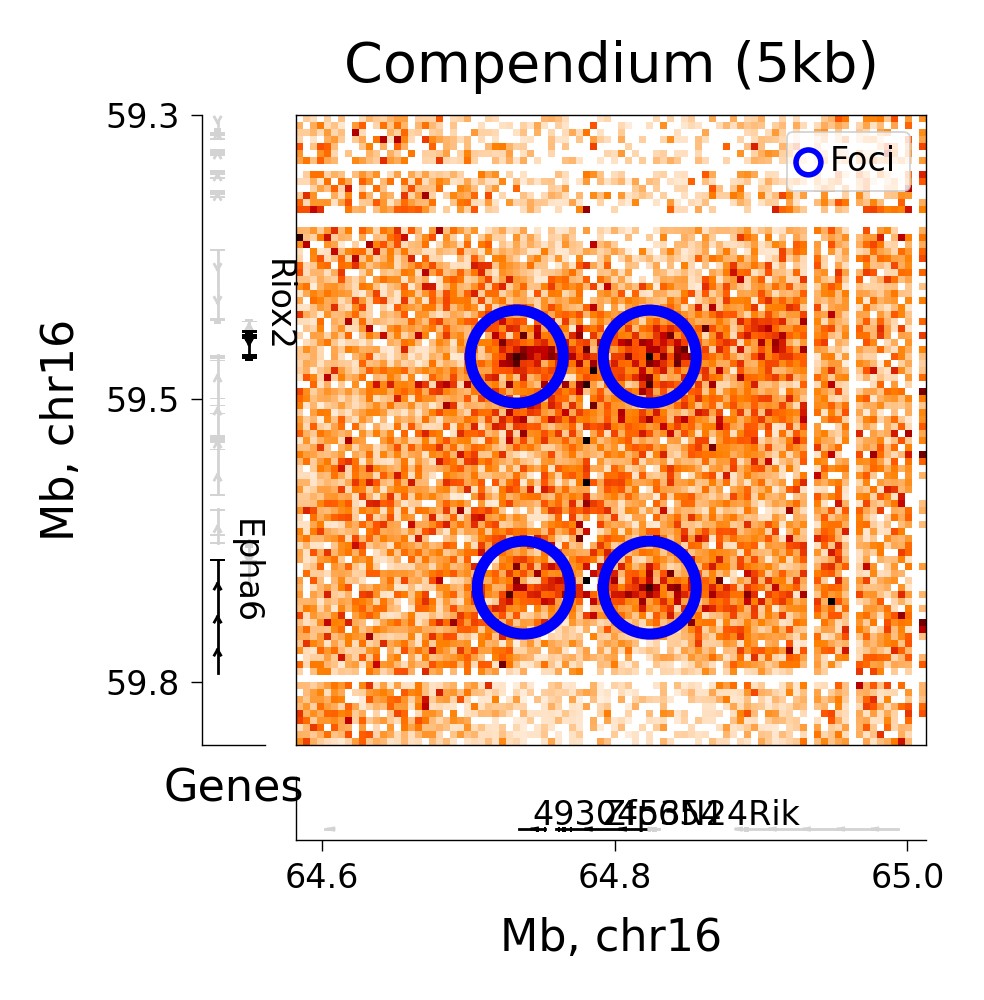

In [14]:
make_figure_6a()

#### Figure S29 A

file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf
file: /Genomics/argo/users/gdolsten/pritlab/jupys/tregs/pygbrowse/Mus_musculus.GRCm38.93.chr.gff3.gz.bgzf


/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


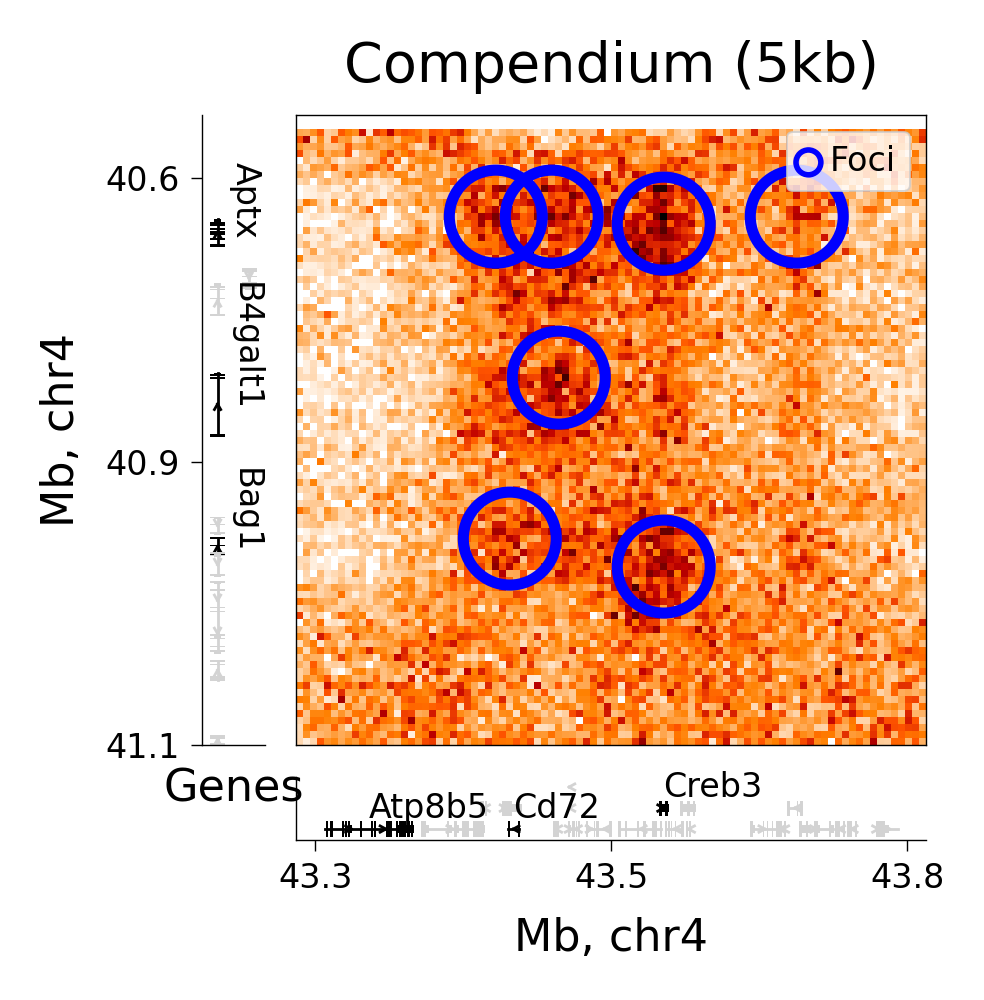

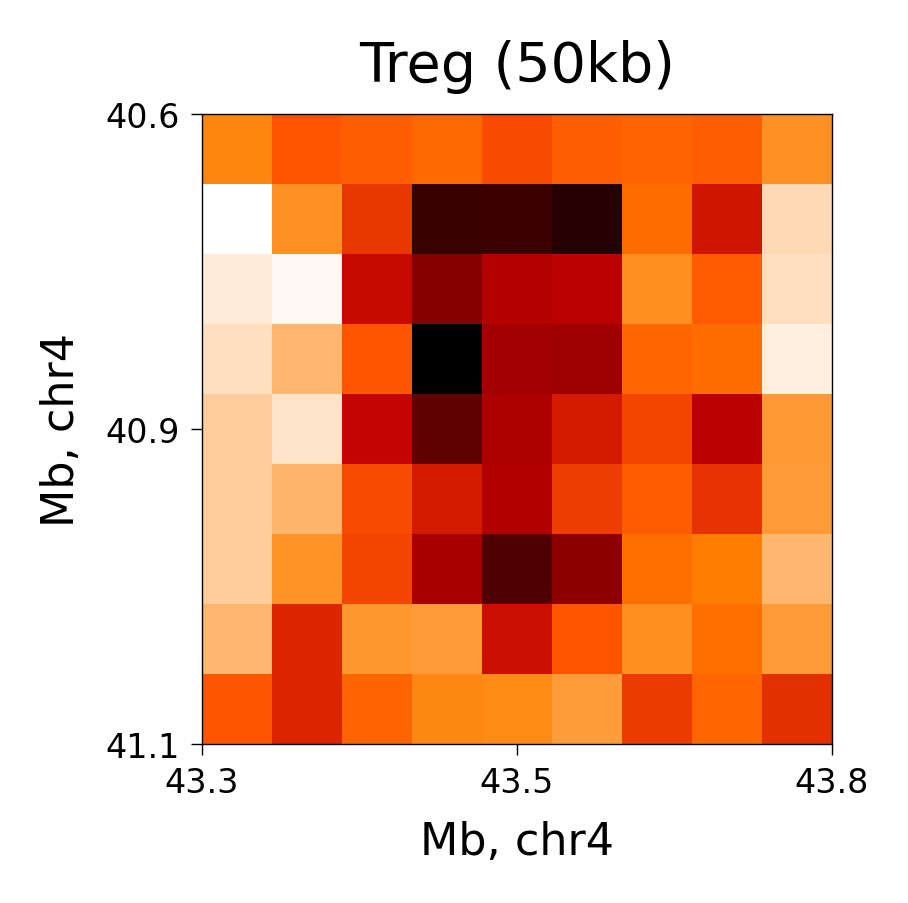

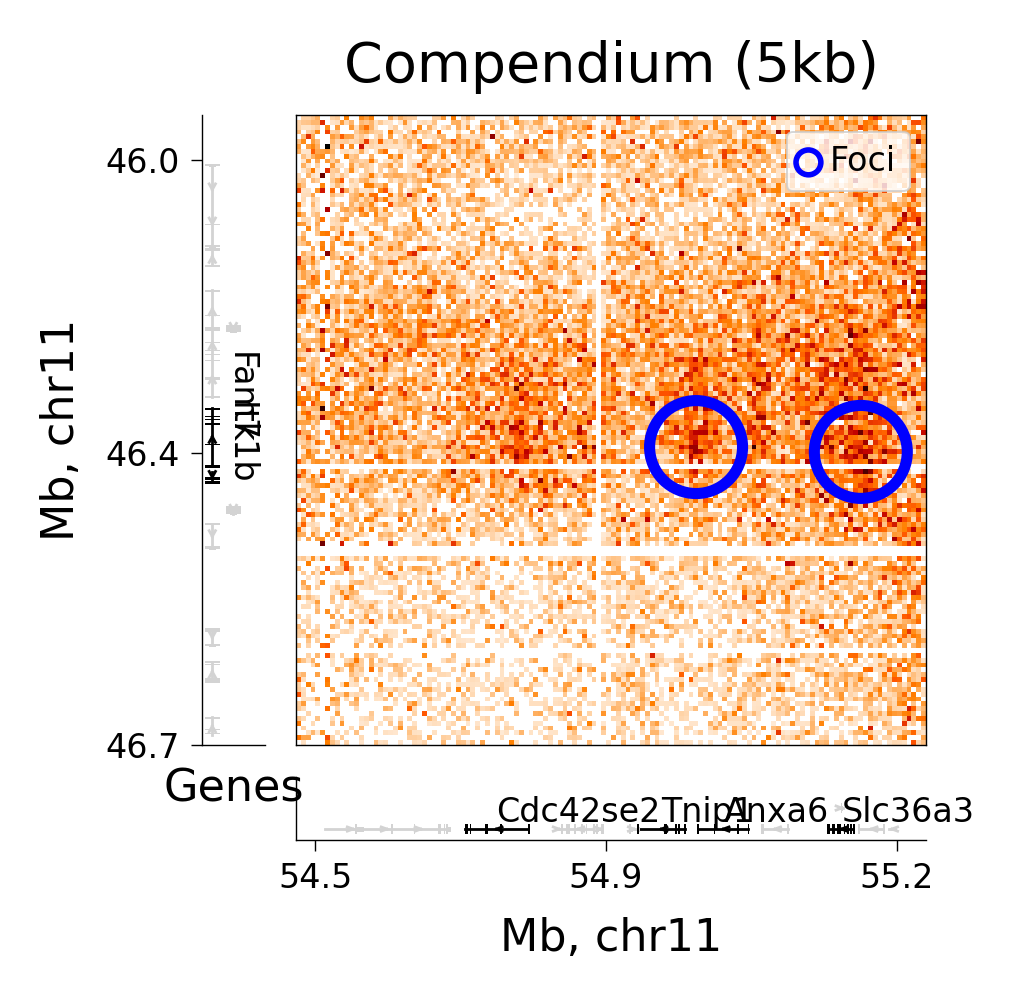

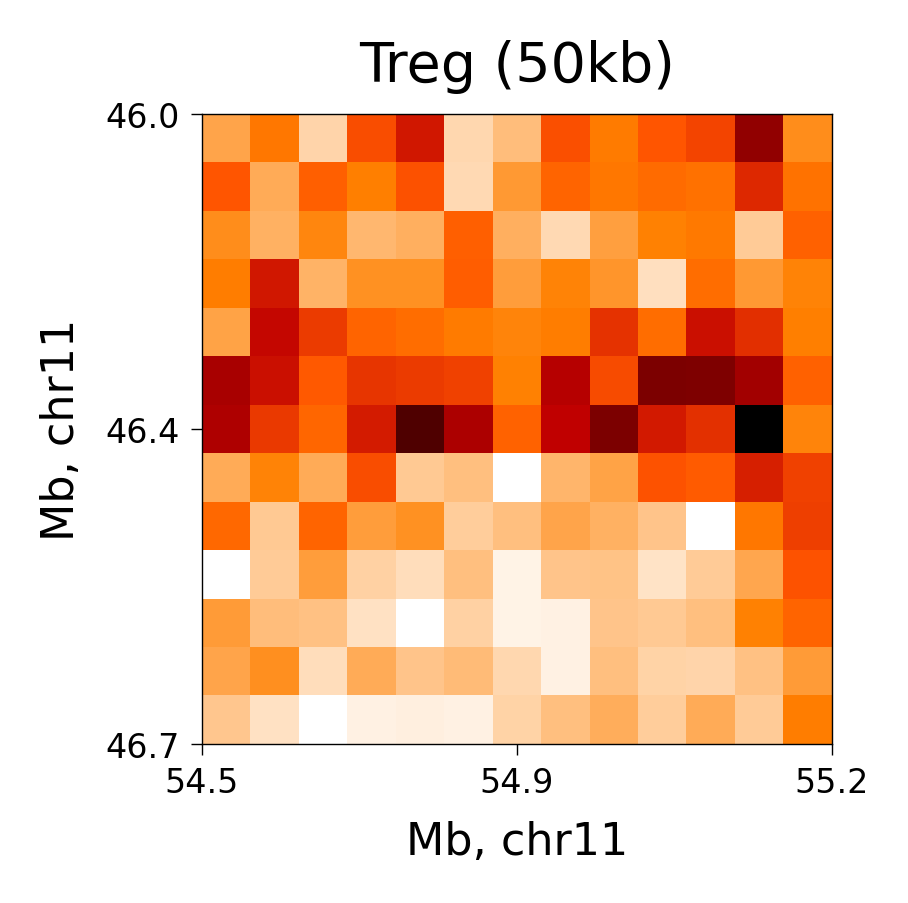

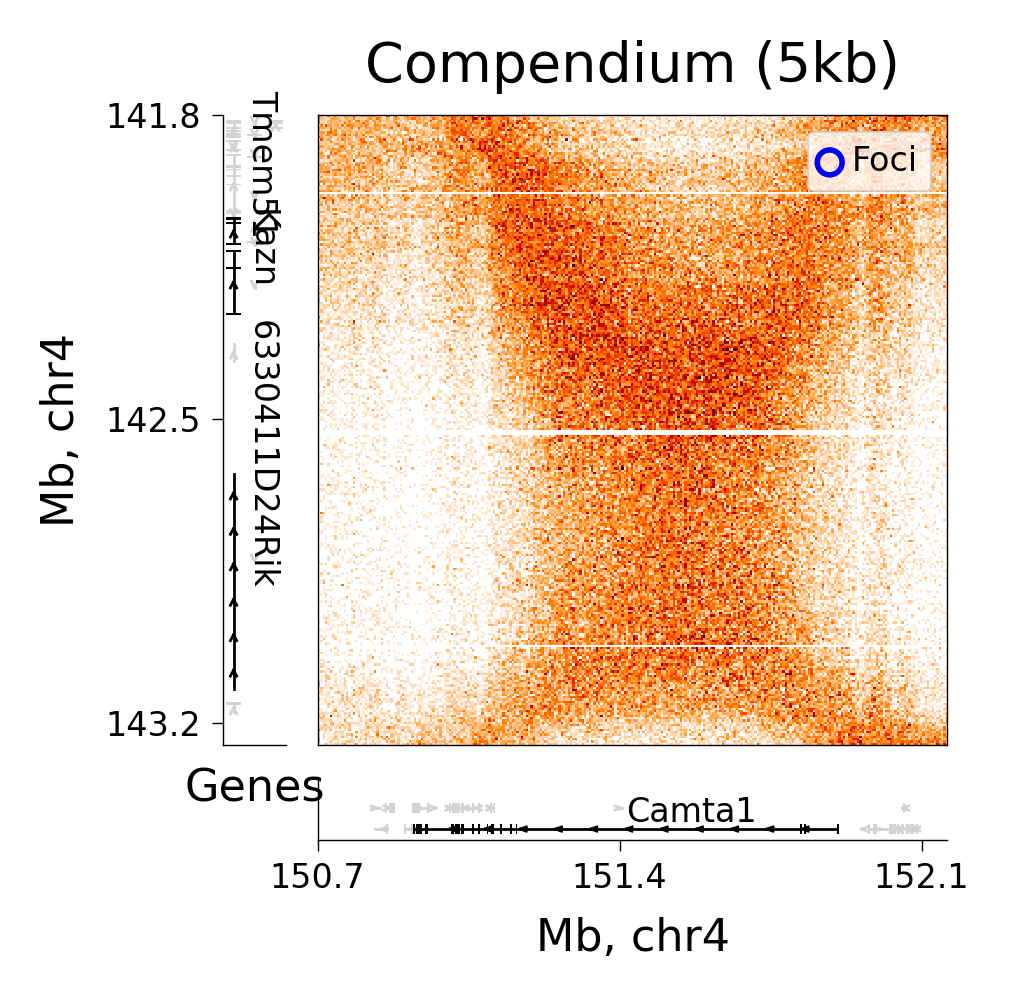

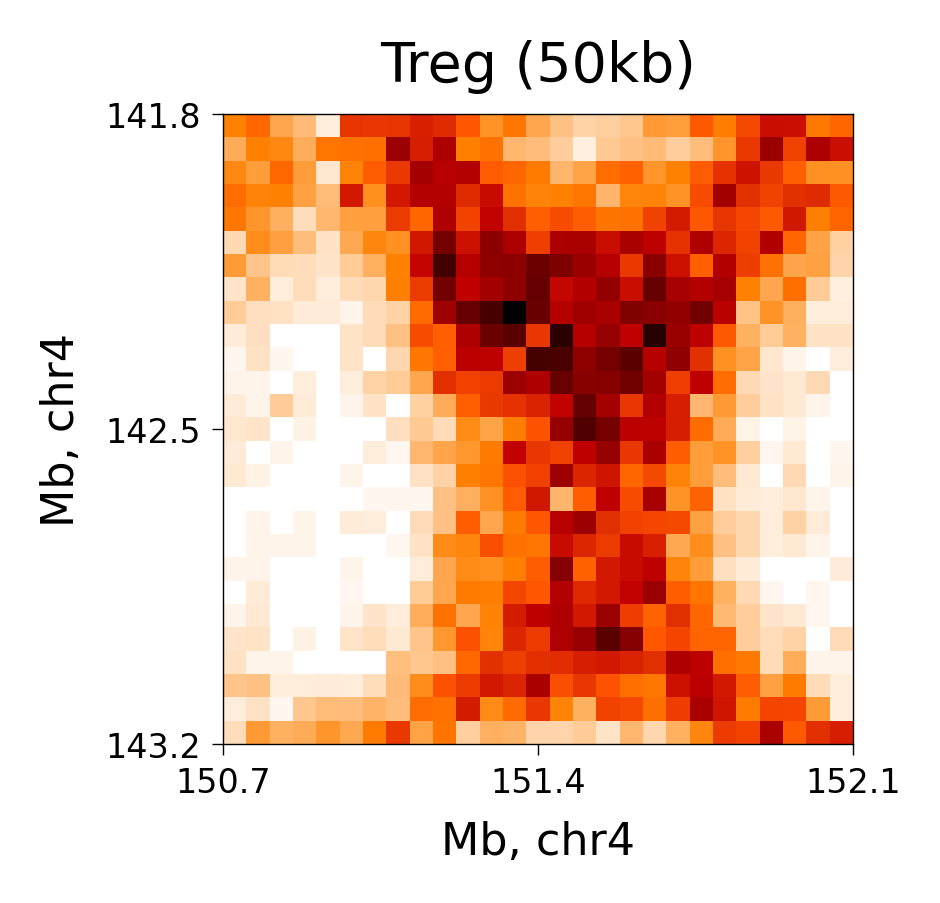

In [15]:
make_figure_s29a()

#### Add gene annotations to 5kb anchors

In [16]:
all_metaloops = pbt.BedTool("final_loops/metaloops/refined_metaloops/refined_metaloops.bed")
all_metaloop_anchors = pbt.BedTool("final_loops/metaloops/refined_metaloops/refined_metaloop_anchors.bed")
metaloop_anchor_counts = all_metaloop_anchors.to_dataframe().value_counts().reset_index()

In [17]:
def drop_bedtool_duplicates(bedtool, cutoff = 0):
    l = bedtool.to_dataframe().value_counts().reset_index()
    l = l[l['count'] > cutoff]
    return pbt.BedTool.from_dataframe(l)

In [18]:
df = pd.read_csv("./intermediate_files/metaloop_gene_pairs")

In [19]:
all_metaloops = pbt.BedTool("final_loops/metaloops/refined_metaloops/refined_metaloops.bed")
all_metaloop_anchors = pbt.BedTool("final_loops/metaloops/refined_metaloops/refined_metaloop_anchors.bed")

loop_anchors = add_chr_to_bedtool(pbt.BedTool('final_loops/processed_DESEQ/thresh=0/all_ancs.csv'))
# Deduplicate
dedup_all_metaloop_anchors = drop_bedtool_duplicates(add_chr_to_bedtool(all_metaloop_anchors), cutoff=0)

shifted_dedup_all_metaloop_anchors = dedup_all_metaloop_anchors.shift(s=50_000, genome='mm10')

### Figure 6D

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-

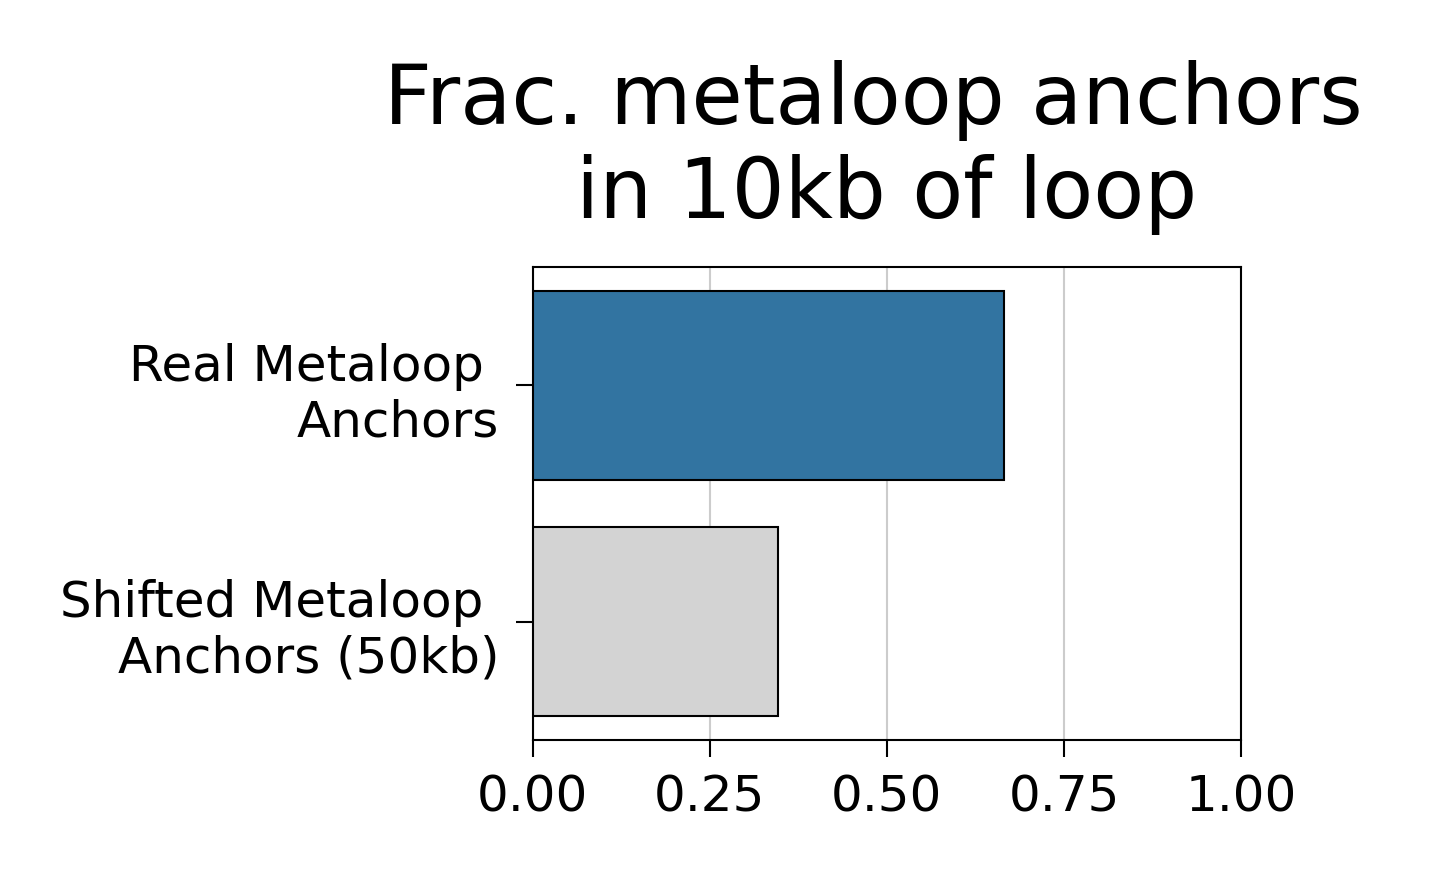

In [20]:
from plotting_functions import *

bound = 10_000
p = bedprop(dedup_all_metaloop_anchors, loop_anchors.slop(b=bound, genome='mm10').saveas())
p_shift = bedprop(dedup_all_metaloop_anchors.shift(s=50_000, genome='mm10'), loop_anchors.slop(b=bound, genome='mm10').saveas())

fig, axs = init_subplots_exact(1, 1, fgsz=(mm*30, mm*20), dpi=300)
sns.barplot(y=['Real Metaloop \nAnchors', 'Shifted Metaloop \nAnchors (50kb)',], x=[p, p_shift], orient='h', palette = ['tab:blue', 'lightgray'],
           linewidth=.25, edgecolor='black', zorder=3)
plt.title("Frac. metaloop anchors \nin 10kb of loop")
plt.xlim([0, 1])
fig.savefig('./plots/paper/fig6/foci_with_anchor.pdf', bbox_inches='tight', dpi=300)

In [21]:
p = bedprop(dedup_all_metaloop_anchors, loop_anchors.slop(b=bound, genome='mm10').saveas())
p_shift = bedprop(dedup_all_metaloop_anchors.shift(s=50_000, genome='mm10'), loop_anchors.slop(b=bound, genome='mm10').saveas())

In [22]:
scipy.stats.fisher_exact([[int(p*len(dedup_all_metaloop_anchors)), int((1-p)*len(dedup_all_metaloop_anchors))],
                          [int(p_shift*len(dedup_all_metaloop_anchors)), int((1-p_shift)*len(dedup_all_metaloop_anchors))]
                         ],)

SignificanceResult(statistic=3.7471170700642, pvalue=0.0)

### Include hub analysis

In [23]:
goodinds = pickle.load(open('./intermediate_files/goodinds', 'rb'))
merged_clustdict = pickle.load(open('./intermediate_files/merged_clustdict', 'rb'))

In [24]:
cluster_labels = [list(all_ind_to_region[x]) + [merged_clustdict['all'][c]] for c, x in enumerate(goodinds)]
cluster_labels = pd.DataFrame(cluster_labels)
cluster_labels = cluster_labels[cluster_labels[3].isin([0, 4, 18])]
cluster_labels = add_chr_to_bedtool(pbt.BedTool.from_dataframe(cluster_labels))

### Show which metadomains have more metaloops

In [25]:
def add_stat_annotation(ax, data, xcol, ycol, order, box_pairs, ymax=1.2, delta=0.1):
    """Add statistical annotations for comparing different y values."""
    y_positions = {v: i for i, v in enumerate(order)}
    yoff = 0
    print(y_positions)
    seen = set()
    for c, pair in enumerate(box_pairs):
        
        yoff += delta
        
        data1 = data[data[ycol] == pair[0]][xcol]
        data2 = data[data[ycol] == pair[1]][xcol]

        stat, p_value = nonan_test(data1, data2)
    
        y1 = y_positions[pair[0]]
        y2 = y_positions[pair[1]]
        
        y = ymax + yoff
        h, col = 1.015, 'k'
        
        ax.plot([y, y * h, y * h, y], [y1, y1, y2, y2], lw=0.25, c=col)
        ax.text((y * h), (y1+y2) / 2, f'{format_pval_as_asterisks(p_value)}', ha='left', va='center', color=col,
                rotation=-90,
                fontsize=4)

In [26]:
all_intra_treg_metadomains = np.load('intermediate_files/all_intra_treg_metadomains.npy') > 0
all_intra_tcon_metadomains = np.load('intermediate_files/all_intra_tcon_metadomains.npy') > 0

all_intra_metadomains = (all_intra_treg_metadomains + all_intra_tcon_metadomains > 0)

In [27]:
w1 = cluster_labels.to_dataframe()
w1 = w1.iloc[:, :4]
w1.columns = ['chrom', 'start', 'end', 'cluster']

w2 = pbt.BedTool(add_chr_to_bedtool(all_ind_to_region)).intersect(add_chr_to_bedtool(all_metaloop_anchors), c=True).to_dataframe()
w2.columns = ['chrom', 'start', 'end', 'n_foci']

data = pd.concat([w1.set_index(['chrom', 'start', 'end']),
                 w2.set_index(['chrom', 'start', 'end']),
           ], axis=1).fillna("Other").reset_index()

In [28]:
my_treg_comp = np.load('./intermediate_files/my_treg_comp.npy')
granges = [] 
for _, row in data.iterrows():
    granges.append(tuple_to_grange(row.chrom[3:], row.start, row.end))
data.index = granges

granges_in_order = [tuple_to_grange(*x) for x in all_ind_to_region]
data = data.loc[granges_in_order]
data['compartment'] = my_treg_comp > .9
data['cluster'][(data['cluster'] == 'Other') &  (data['compartment'] > 0)] = 'A'
data['n_metaloops']= all_intra_metadomains.sum(axis=1)
data = data[data['n_metaloops'] > 0]
data['metaloops_per_metadomain']= data['n_foci'] / data['n_metaloops']

/tmp/ipykernel_1660492/1160864244.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'][(data['cluster'] == 'Other') &  (data['compartment'] > 0)] = 'A'


#### Figure 6G

/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Genomics/argo/users/gdolsten/.conda/envs/mamba/envs/new_3dgenome/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


{'A': 0, 0: 1, 4: 2, 18: 3, 'Other': 4}


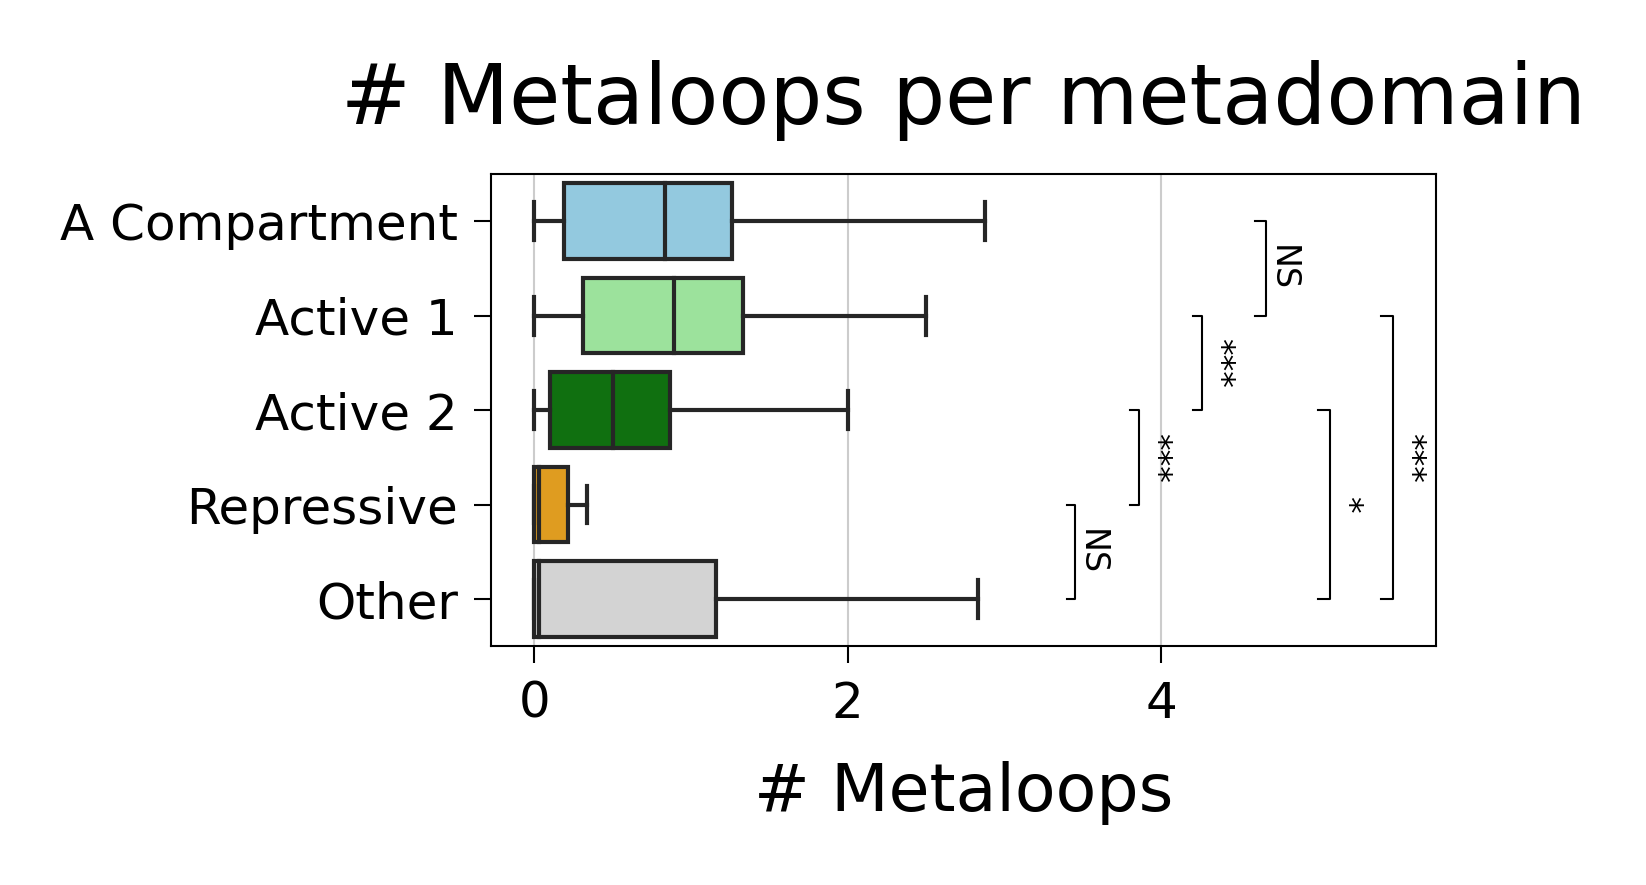

In [29]:
order = ['A', 0, 4, 18, 'Other', ]
fig, axs = init_subplots_exact(1, 1, fgsz=(40*mm, 20*mm), dpi=300)
sns.boxplot(data = data, y = 'cluster', x = 'metaloops_per_metadomain', #cut=0, 
            palette = ['skyblue', 'lightgreen', 'green', 'orange', 'lightgray'],
            orient='h',
            order = order,
            showfliers=False,
           #   width = 1.2,
           )
plt.gca().set_yticklabels(["A Compartment", "Active 1", "Active 2", "Repressive", "Other"])
plt.title("# Metaloops per metadomain")
plt.xlabel("# Metaloops")
plt.ylabel("")
plt.gca().set_axisbelow(True)

add_stat_annotation(plt.gca(), data, 'metaloops_per_metadomain', 'cluster', order, [
                                                                             [18, 'Other'],
                                                                             [4, 18],
                                                                             [0, 4],
                                                                             ['A', 0],
                                                                             [4, 'Other'],
                                                                             [0, 'Other'],
                                                                            ], ymax=3, delta=.4)

In [32]:
from plotting_functions import *
from get_focal_contacts_with_peak_prominence_refine import *

def make_figure_6e_f():
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')

    _2 = plot_from_cooler_and_anchors(coolfile, 
                                  ['4', 40750000, 41000000],
                                  ['4', 123250000+150_00, 123500000+150_00],
                                 d=300_000, cols=1, fgsz = (20*mm, 20*mm))
    plt.grid(False)
    plt.title('Treg (50kb)')
    _2.savefig('./plots/FINAL_MEGA_PLOTS/active1_active1.pdf', bbox_inches='tight', dpi=200)
        
    _ = make_comprehensive_plot_grange_collapsing(
                                  ['4', 40750000, 41000000],
                                  ['4', 123250000+150_00, 123500000+150_00],
                                  extend_by=300_000,
                                  logp_co=15, s = 60, linewidth = .5,
                                  fgsz=(20*mm, 20*mm));
    
    _[0].axes[0].grid(False)
    _[0].savefig('./plots/FINAL_MEGA_PLOTS/active1_active1_zoom.pdf', bbox_inches='tight')



    _ = make_comprehensive_plot_grange_collapsing(
                                  ['2', 154000000-60_000, 154250000-60_000],
                                  ['2', 166250000-60_000, 166500000-60_000],
                                extend_by=400_000, logp_co=15, fgsz=(20*mm, 20*mm));
    _[0].axes[0].grid(False)
    _[0].savefig('./plots/FINAL_MEGA_PLOTS/repr_repr_zoom.pdf', bbox_inches='tight')
    
    coolfile = cooler.Cooler('./Treg_all.mcool::/resolutions/50000')
    
    _2 = plot_from_cooler_and_anchors(coolfile, 
                                      ['2', 154000000-60_000, 154250000-60_000], ['2', 166250000-60_000, 166500000-60_000],
                                      d=400_000, fgsz=(20*mm, 20*mm), cols=1)
    plt.grid(False)
    plt.title('Treg (50kb)')
    _2.savefig('./plots/FINAL_MEGA_PLOTS/repr_repr.pdf', bbox_inches='tight', dpi=200)

/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Genomics/pritykinlab/gabe/jupys/tregs/./code/get_focal_contacts_with_peak_prominence_refine.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


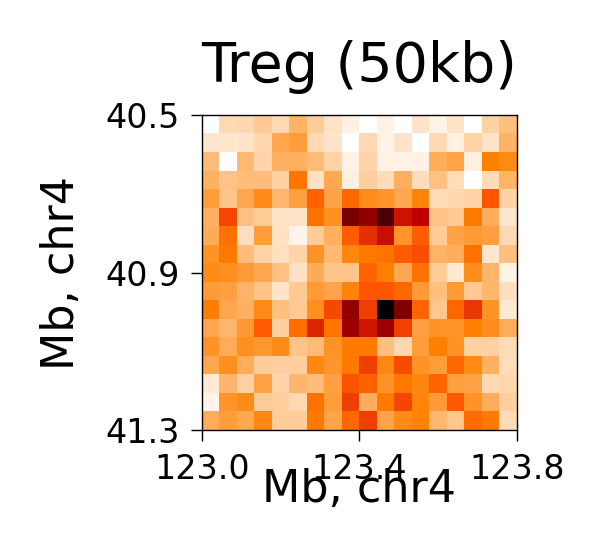

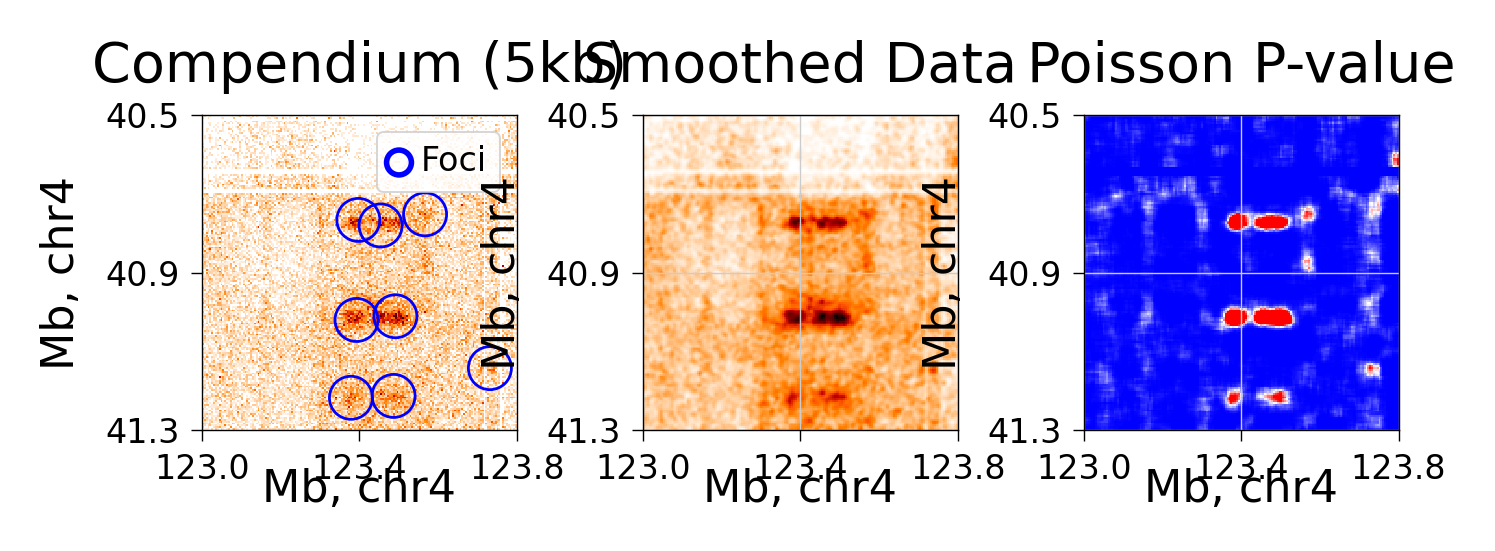

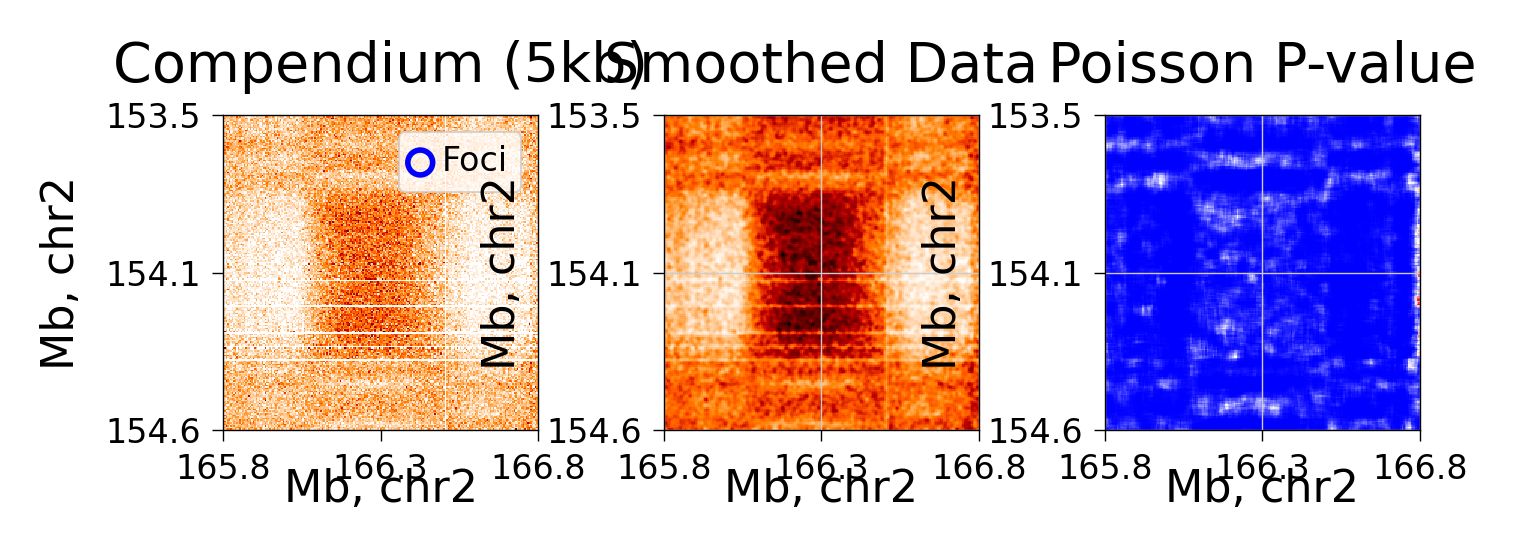

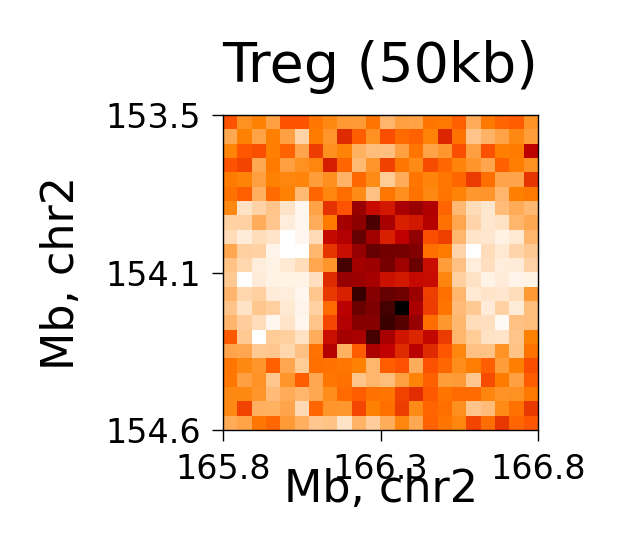

In [33]:
make_figure_6e_f()